## TRASNFER LEARNING: INITIAL TEST

### Introduction

### Libraries

In [16]:
#basic
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

#tensorflow and keras
from tensorflow import keras
from keras.layers import Input, Dense, GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import Model
from keras_preprocessing.image import ImageDataGenerator
from keras.applications import ResNet50

#sklearn
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

### Functions

In [17]:
from utils import transform_diagnosis_to_numerical, add_prefix_to_string, predict_image, probability_to_categorical, plot_confusion_matrix

### Globals

In [18]:
RANDOM_SEED = 42
EPOCHS = 100

### Reading data 

In [19]:
dataframe = pd.read_csv("../../../../src/data/zr7vgbcyr2-1/metadata.csv")
image_file_names_and_diagnosis = dataframe[["img_id", "diagnostic"]]

### Data transformations

In [20]:
image_file_names_and_diagnosis["img_id"] = image_file_names_and_diagnosis["img_id"].apply(
    lambda string: add_prefix_to_string(string, "../../../../src/data/zr7vgbcyr2-1/images/all_images/"))

/tmp/ipykernel_55188/2060156290.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  image_file_names_and_diagnosis["img_id"] = image_file_names_and_diagnosis["img_id"].apply(


In [21]:
image_file_names_and_diagnosis.head()

,img_id,diagnostic
0,../../../../src/data/zr7vgbcyr2-1/images/all_i...,NEV
1,../../../../src/data/zr7vgbcyr2-1/images/all_i...,BCC
2,../../../../src/data/zr7vgbcyr2-1/images/all_i...,ACK
3,../../../../src/data/zr7vgbcyr2-1/images/all_i...,ACK
4,../../../../src/data/zr7vgbcyr2-1/images/all_i...,BCC


In [22]:
image_file_names_and_diagnosis.img_id[0]

'../../../../src/data/zr7vgbcyr2-1/images/all_images/PAT_1516_1765_530.png'

### Split data in train, test and validation

In [23]:
stratified_shuffle_split_train_test = StratifiedShuffleSplit(
    n_splits=1,
    test_size=0.2,
    random_state=RANDOM_SEED,
)
stratified_shuffle_split_train_val = StratifiedShuffleSplit(
    n_splits=1,
    test_size=0.1,
    random_state=RANDOM_SEED,
)

In [24]:
for train_index, test_index in stratified_shuffle_split_train_test.split(
    image_file_names_and_diagnosis,
    image_file_names_and_diagnosis["diagnostic"]):
        stratified_train_and_validation_set = image_file_names_and_diagnosis.iloc[train_index]
        stratified_test_set = image_file_names_and_diagnosis.iloc[test_index]

In [25]:
for train_index, validation_index in stratified_shuffle_split_train_val.split(
    stratified_train_and_validation_set,
    stratified_train_and_validation_set["diagnostic"]):
        stratified_train_set = stratified_train_and_validation_set.iloc[train_index]
        stratified_validation_set = stratified_train_and_validation_set.iloc[validation_index]

In [26]:
stratified_train_set = stratified_train_set.reset_index()
stratified_validation_set = stratified_validation_set.reset_index()
stratified_test_set = stratified_test_set.reset_index()

In [27]:
print("Examples in train set: {0}".format(stratified_train_set.shape[0]))
print("Examples in validation set: {0}".format(stratified_validation_set.shape[0]))
print("Examples in test set: {0}".format(stratified_test_set.shape[0]))

Examples in train set: 1654
Examples in validation set: 184
Examples in test set: 460


### Generate tensorflow objects

In [28]:
class_names = dataframe.diagnostic.value_counts().index.tolist()

In [29]:
#create the ImageDataGenerator object
train_data_augmentation_generator = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
)
#train_data_augmentation_generator.fit(stratified_train_set)

validation_data_augmentation_generator = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
)
#validation_data_augmentation_generator.fit(stratified_validation_set)

In [32]:
#generate batches and augment the images
train_data_generator = train_data_augmentation_generator.flow_from_dataframe(
    stratified_train_set,
    x_col='img_id',
    y_col='diagnostic',
    class_mode='categorical',
    classes=class_names,
    target_size=(224, 224),
)

validation_data_generator = train_data_augmentation_generator.flow_from_dataframe(
    stratified_validation_set,
    x_col='img_id',
    y_col='diagnostic',
    class_mode='categorical',
    classes=class_names,
    target_size=(224, 224),
)

Found 1654 validated image filenames belonging to 6 classes.
Found 184 validated image filenames belonging to 6 classes.


### Prepare the model

In [33]:
#initialize the pretrained model
feature_extractor = ResNet50(
    weights='imagenet', 
    input_shape=(224, 224, 3),
    include_top=False #whether to include the fully-connected layer at the top of the network.
)

2022-08-22 17:18:17.659188: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-22 17:18:17.686046: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2022-08-22 17:18:17.686057: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1850] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2022-08-22 17:18:17.686508: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN

In [34]:
feature_extractor.trainable = False #to make sure it's not being trained
input_layer = Input(shape=(224, 224, 3))
pre_treined_model = feature_extractor(input_layer, training=False) #add input layer
pre_treined_model_with_polling = GlobalAveragePooling2D()(pre_treined_model) #add pooling layer
output_layer = Dense(6, activation='softmax')(pre_treined_model_with_polling)

In [35]:
model = Model(input_layer, output_layer)

In [36]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

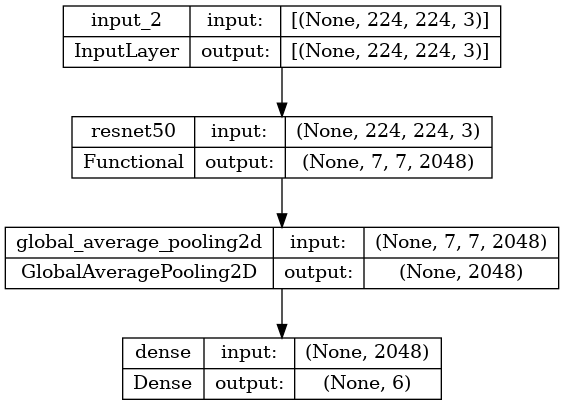

In [37]:
keras.utils.plot_model(model, "ResNet50.png", show_shapes=True)

In [38]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 6)                 12294     
                                                                 
Total params: 23,600,006
Trainable params: 12,294
Non-trainable params: 23,587,712
_________________________________________________________________


### Train the model

In [39]:
'''best_model_checkpoint = ModelCheckpoint(
    filepath= "/home/fernandofincatti/Documents/insper/pfe/ComputerAidedSkinCancerIdentificationAndDiagnosis/experiments/fernando/transfer-learning/test01/model",
    monitor='acc',
    save_best_only= True,
    save_weights_only = True
)'''
best_model_checkpoint = EarlyStopping(
    monitor='val_loss',
    mode='min',
    verbose=1,
    patience=10,
    restore_best_weights=True
)

In [40]:
#model = keras.models.load_model('/home/fernandofincatti/Documents/insper/pfe/ComputerAidedSkinCancerIdentificationAndDiagnosis/experiments/fernando/transfer-learning/test01/model')

training_history = model.fit(
    x = train_data_generator,
    epochs = EPOCHS,
    validation_data = validation_data_generator,
    callbacks=[best_model_checkpoint]
)
model.save(filepath="/home/fernandofincatti/Documents/insper/pfe/ComputerAidedSkinCancerIdentificationAndDiagnosis/experiments/fernando/transfer-learning/test01/model")

/home/fernandofincatti/.local/lib/python3.10/site-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/fernandofincatti/.local/lib/python3.10/site-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


52/52 [==============================] - 120s 2s/step - loss: 1.3981 - accuracy: 0.4637 - val_loss: 1.2143 - val_accuracy: 0.5326


### Test the model

In [41]:
stratified_test_set["prediction"] = stratified_test_set.apply(
    lambda data: predict_image(model, data["img_id"]), axis=1
)

1/1 [==============================] - 0s 53ms/step


In [49]:
stratified_test_set["prediciton_to_categorical"] = stratified_test_set["prediction"].apply(
    lambda data: probability_to_categorical(data, class_names)
)

In [55]:
stratified_test_set

,index,img_id,diagnostic,prediction,prediciton_to_categorical
0,11,../../../../src/data/zr7vgbcyr2-1/images/all_i...,BCC,"[[0.67081106, 0.23054129, 0.0037888682, 0.0200...",BCC
1,719,../../../../src/data/zr7vgbcyr2-1/images/all_i...,BCC,"[[0.06238459, 0.6620359, 0.029439814, 0.169742...",ACK
2,305,../../../../src/data/zr7vgbcyr2-1/images/all_i...,ACK,"[[0.26585668, 0.3274782, 0.06546687, 0.1029244...",ACK
3,2034,../../../../src/data/zr7vgbcyr2-1/images/all_i...,NEV,"[[0.0005003591, 0.11796279, 0.009183295, 0.860...",SEK
4,2098,../../../../src/data/zr7vgbcyr2-1/images/all_i...,ACK,"[[0.5142747, 0.11422083, 0.039064806, 0.087811...",BCC
...,...,...,...,...,...
455,331,../../../../src/data/zr7vgbcyr2-1/images/all_i...,SEK,"[[0.057131782, 0.06362237, 0.097788684, 0.4973...",SEK
456,1747,../../../../src/data/zr7vgbcyr2-1/images/all_i...,ACK,"[[0.34521177, 0.22895361, 0.025335118, 0.22239...",BCC
457,1506,../../../../src/data/zr7vgbcyr2-1/images/all_i...,BCC,"[[0.067731105, 0.5387197, 0.0013944458, 0.0852...",ACK
458,1093,../../../../src/data/zr7vgbcyr2-1/images/all_i...,ACK,"[[0.43409696, 0.3634729, 0.010431812, 0.012200...",BCC


In [64]:
hit = np.where(
    stratified_test_set['diagnostic']==stratified_test_set['prediciton_to_categorical'],
    1,
    0).sum()
print("Total score = {0}%".format(
    round(hit*100/stratified_test_set.shape[0], 2)
))

Total score = 19.57%


<AxesSubplot:title={'center':'Normalized confusion matrix'}, xlabel='Predicted label', ylabel='True label'>

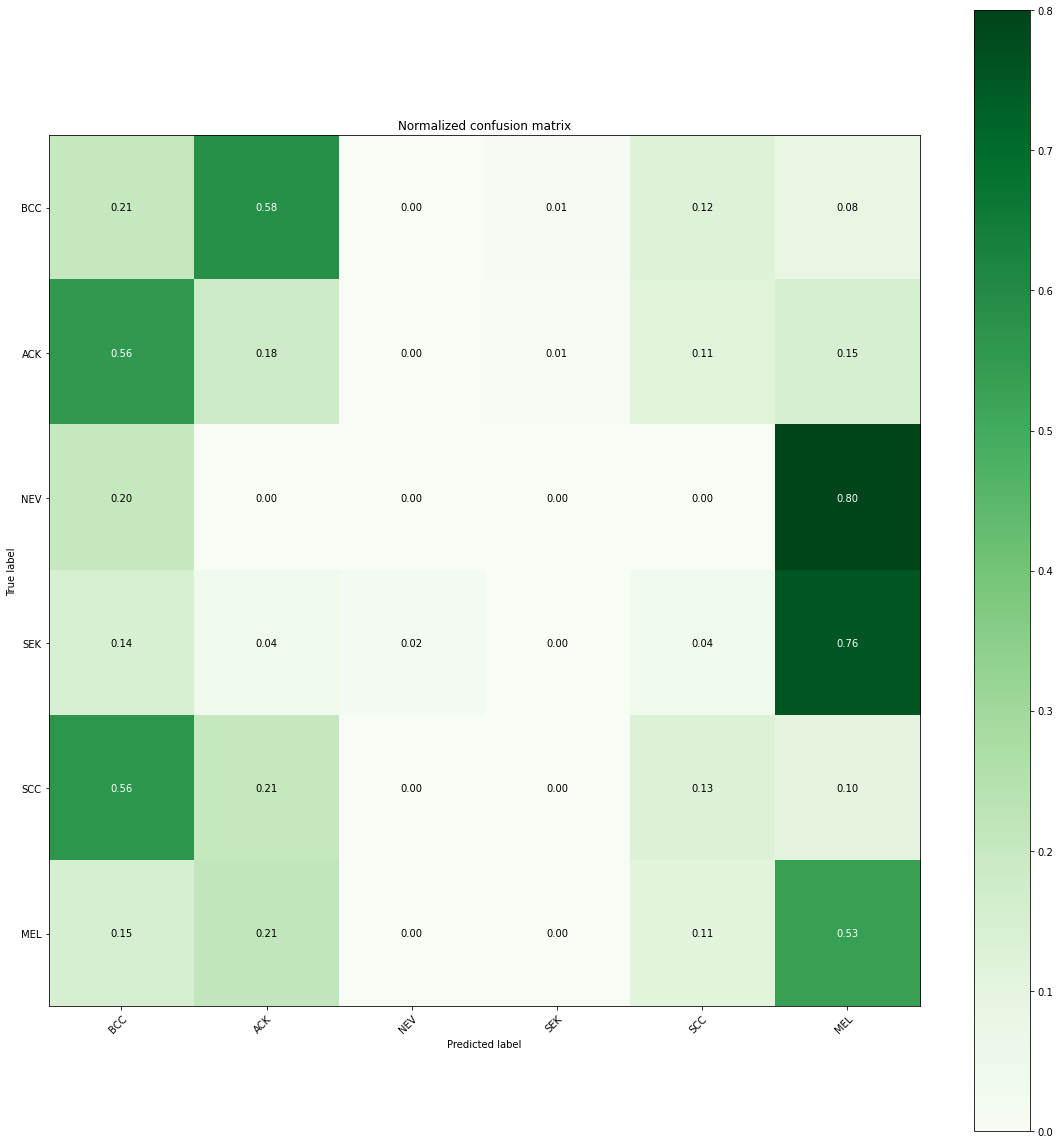

In [54]:
plot_confusion_matrix(
    stratified_test_set["diagnostic"],
    stratified_test_set["prediciton_to_categorical"],
    class_names
    )